In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# --- 1. Load Data ---
team_fb = pd.read_csv("C:/Users/ASUS/Desktop/team_merged.csv")

# Load Understat data
league_list = ['epl', 'laliga', 'serieA', 'bundesliga', 'ligue1']
us_dfs = []

for league in league_list:
    path = f'C:/Users/ASUS/Documents/Big 5 leagues data/Understat Teams/25-26/{league}_understat_25-26.csv'
    df = pd.read_csv(path)
    us_dfs.append(df)

team_us = pd.concat(us_dfs, ignore_index=True)

In [3]:
# --- PRE-PROCESSING: FILTER SEASONS ---

# 1. Check available years 
print("Available Seasons in FBref:", team_fb['Season_End_Year'].unique())

# 2. Filter for ONLY the 2025 season 
team_fbref_filtered = team_fb[team_fb['Season_End_Year'] == 2025].copy()

# 3. Validation Check
print(f"\nOriginal Row Count: {len(team_fb)}")
print(f"Filtered Row Count: {len(team_fbref_filtered)}")

team_fb = team_fbref_filtered

Available Seasons in FBref: [2023 2021 2022 2024 2025]

Original Row Count: 486
Filtered Row Count: 96


In [4]:
# --- 2. Clean and Merge ---
# Standardize names for merging
team_fb['Team_Clean'] = team_fb['Team'].str.lower().str.strip()
team_us['Team_Clean'] = team_us['team'].str.lower().str.strip()

# Map common name differences
name_map = {
    'manchester utd': 'manchester united',
    'nott\'m forest': 'nottingham forest',
    'wolves': 'wolverhampton wanderers',
    'bayer lev': 'bayer leverkusen',
    'inter': 'inter milan'
}
team_fb['Team_Clean'] = team_fb['Team_Clean'].replace(name_map)

# Merge
combined_df = pd.merge(team_fb, team_us, on='Team_Clean', how='inner', suffixes=('', '_us'))

In [5]:
def process_data(df):
    # Create a new dataframe for the style metrics
    df_style = pd.DataFrame()
    
    # 1. Basic Info
    df_style['Team'] = df['Team']
    
    # 2. Pressing Intensity (PPDA from Understat)
    # Lower value = Higher intensity
    df_style['Pressing Intensity'] = df['ppda']
    
    # 3. Pressing Resistance (OPPDA from Understat)
    # How many passes allowed per defensive action
    df_style['Pressing Resistance'] = df['ppda_allowed']
    
    # 4. Possession (FBref)
    df_style['Possession'] = df['Poss']
    
    # 5. Field Tilt (Calculated from FBref Touches)
    # Share of possession in the final third
    df_style['Field tilt %'] = df['Att_3rd_Touches'] / (df['Att_3rd_Touches'] + df['Def_3rd_Touches'])
    
    # 6. Tempo
    # High Passes per Touch = Fast Circulation / Low Dribbling
    # Passes attempted per Touch
    df_style['Tempo'] = (df['Att_Total'] * 100) / df['Touches_Touches']
    
    # 7. Directness
    # Progressive Distance / Total Distance of passes
    df_style['Directness'] = (df['PrgDist_Total'] * 100) / df['TotDist_Total']
    
    # 8. Defensive Height (Weighted Average of Tackles)
    total_tackles = df['Def_3rd_Tackles'] + df['Mid_3rd_Tackles'] + df['Att_3rd_Tackles']
    
    pct_def3rd = df['Def_3rd_Tackles'] / total_tackles
    pct_mid3rd = df['Mid_3rd_Tackles'] / total_tackles
    pct_att3rd = df['Att_3rd_Tackles'] / total_tackles 
    
    # Calculation: (Def% * 18m) + (Mid% * 54m) + (Att% * 90m) roughly
    df_style['Defensive height'] = (pct_def3rd * 16.5 * 1.1) + \
                                   (pct_mid3rd * 49.5 * 1.1) + \
                                   (pct_att3rd * 82.5 * 1.1)
    
    # 9. Crossing
    # Crosses into Penalty Area per 90 
    df_style['Crossing'] = df['CrsPA'] / df['Mins_Per_90']
    
    # 10. Air Duels (Total Aerials)
    df_style['Air duels'] = df['Won_Aerial'] + df['Lost_Aerial']
    
    # 11. Set Pieces (Shot Creating Actions from Dead Balls)
    df_style['Set Pieces'] = df['PassDead_SCA']
    
    # 12. Dribbling (Take-ons Attempted per Touch)
    df_style['Dribbling'] = df['Att_Take'] / df['Touches_Touches']

    # 13. Width / Crossing Reliance 
    # How much does the team rely on crosses compared to total passes?
    df_style['Width'] = df['Crs'] / df['Att_Total']
    
    # 14. Shot Patience 
    # Average Distance of Shots (Lower = Work ball into box, Higher = Long shots)
    df_style['Shot_Distance'] = df['Dist_Standard']
    
    # 15. Aggression 
    # Fouls committed per Defensive Action (Tackles + Interceptions + Fouls)
    total_def_actions = df['Tkl_Tackles'] + df['Int'] + df['Fls']
    df_style['Aggression'] = df['Fls'] / total_def_actions


    return df_style

# Run the processing
df_style = process_data(combined_df)



In [6]:
def data_normalization(df):
    df_norm = df.copy()
    
    # Columns where Higher = Better/More Style
    columns_to_max = [
        'Dribbling', 'Set Pieces', 'Air duels', 'Crossing', 
        'Pressing Resistance', 'Possession', 'Field tilt %', 
        'Tempo', 'Directness', 'Defensive height', 'Aggression', 'Width'
    ]
    
    for column in columns_to_max:
        df_norm[column] = (df_norm[column] * 100) / df_norm[column].max()

    # Special Case: Pressing Intensity (PPDA)
    # Lower is "better" (more intense), so we invert the calculation
    # Formula: (Min Value * 100) / Team Value
    # 1. PPDA (Lower PPDA = Higher Pressing)
    df_norm['Pressing Intensity'] = (df_norm['Pressing Intensity'].min() * 100) / df_norm['Pressing Intensity']

    # 2. Shot Distance (Lower Distance = Higher "Work into Box" Style)
    # Rename to "Box Focus" for clarity in the chart
    df_norm['Box_Focus'] = (df_norm['Shot_Distance'].min() / df_norm['Shot_Distance']) * 100

    return df_norm

# --- 3. Execute ---
df_style_raw = process_data(combined_df)
df_style_final = data_normalization(df_style_raw)

# View the result
print(df_style_final.head())

          Team  Pressing Intensity  Pressing Resistance  Possession  \
0       alaves           73.590814            40.044944   66.325037   
1       angers           41.059988            45.033708   60.322108   
2      arsenal           75.806452            73.123596   83.308931   
3  aston villa           60.307956            39.595506   73.938507   
4     atalanta           62.114537            60.179775   80.966325   

   Field tilt %      Tempo  Directness  Defensive height   Crossing  \
0     75.539469  88.449861   95.993599         82.731343  77.952756   
1     61.068425  89.733064   84.887177         78.541209  55.442334   
2     93.815844  96.245885   70.473068         97.428571  59.055118   
3     70.577402  93.816818   78.780309         85.959856  44.094488   
4     83.937414  95.998456   72.318568         87.540405  88.976378   

   Air duels  Set Pieces  Dribbling      Width  Shot_Distance  Aggression  \
0  88.336647   98.958333  68.957192  96.989146           17.8   94.43

In [7]:
# --- CONFIGURATION ---
features = [
    'Pressing Intensity', 'Pressing Resistance', 'Possession', 
    'Field tilt %', 'Tempo', 'Directness', 'Defensive height', 
    'Crossing', 'Air duels', 'Set Pieces', 'Dribbling', 'Aggression',
    'Width', 'Box_Focus'
]

# Calculate Global stats for Z-Scores (Style) and Means (Profile)
global_mean = df_style_final[features].mean(numeric_only=True)
global_std = df_style_final[features].std(numeric_only=True)

# --- PART 1: MAIN STYLE (Tactical Vision) ---

def get_team_style(row):
    # Calculate Z-Scores for this specific team
    z = (row[features] - global_mean) / global_std
    
    scores = {}

    # 1. HIGH PRESSING
    scores['High Pressing'] = z['Pressing Intensity'] + z['Field tilt %']

    # 2. POSSESSION
    scores['Possession'] = z['Possession'] + z['Pressing Resistance'] - z['Directness']

    # 3. WING-PLAY
    scores['Wing-Play'] = z['Width'] + z['Crossing']

    # 4. KICK AND RUSH
    scores['Kick and Rush'] = z['Directness'] + z['Air duels'] + (0.5 * z['Aggression'])

    # 5. COUNTER-ATTACK
    scores['Counter-Attack'] = -z['Defensive height'] + z['Tempo'] + z['Directness']

    # 6. PARK THE BUS
    scores['Park the Bus'] = -z['Defensive height'] - z['Pressing Intensity'] - (0.5 * z['Tempo'])


    best_style = max(scores, key=scores.get)
    best_score = scores[best_style]
    

    if best_score < 0.5:
        return "Standard"
    
    return best_style

# Apply Main Style
df_style_final['Main_Style'] = df_style_final.apply(get_team_style, axis=1)


# --- PART 2: TACTICAL PROFILE ---

def get_tactical_profile(row, global_means, feature_map):
    # Calculate raw difference from League Average
    team_stats = row[features]
    diff = team_stats - global_means
    
    # Find top 2 distinct traits (biggest positive outliers)
    top_traits = diff.sort_values(ascending=False).head(2).index.tolist()
    
    # Map to text
    trait1 = feature_map.get(top_traits[0], top_traits[0])
    trait2 = feature_map.get(top_traits[1], top_traits[1])
    
    return f"{trait1} & {trait2}"

# Mapping Dictionary
feature_map = {
    'Possession': 'Control',
    'Pressing Intensity': 'Intense Press',
    'Defensive height': 'High Line',
    'Directness': 'Vertical',
    'Tempo': 'High Tempo',
    'Pressing Resistance': 'Press Resistant',
    'Crossing': 'Cross-Heavy',
    'Air duels': 'Aerial',
    'Set Pieces': 'Set-Piece',
    'Dribbling': 'Dribblers',
    'Width': 'Wing Play',
    'Box_Focus': 'Patient',
    'Aggression': 'Aggressive'
}

# Apply Tactical Profile
df_style_final['Tactical_Profile'] = df_style_final.apply(
    lambda row: get_tactical_profile(row, global_mean, feature_map), axis=1
)

# --- 3. FINAL VIEW ---

output_cols = ['Team', 'Main_Style', 'Tactical_Profile', 'Possession', 'Directness']

print("--- Final Team Analysis ---")
print(df_style_final[output_cols].sort_values('Main_Style'))


print("\n--- Style Distribution ---")
print(df_style_final['Main_Style'].value_counts())

--- Final Team Analysis ---
             Team      Main_Style              Tactical_Profile  Possession  \
23     fiorentina  Counter-Attack    Aggressive & Intense Press   74.670571   
53        sevilla   High Pressing     Intense Press & Dribblers   73.938507   
52           roma   High Pressing     Intense Press & Set-Piece   78.916545   
43         monaco   High Pressing  Intense Press & Field tilt %   80.527086   
11        bologna   High Pressing   Intense Press & Cross-Heavy   85.065886   
..            ...             ...                           ...         ...   
5   athletic club       Wing-Play         Dribblers & Wing Play   70.863836   
47        osasuna       Wing-Play       Cross-Heavy & Wing Play   67.496340   
59        udinese       Wing-Play      Aggressive & Cross-Heavy   69.106881   
25         fulham       Wing-Play       Cross-Heavy & Wing Play   76.573939   
12    bournemouth       Wing-Play       Wing Play & Cross-Heavy   71.010249   

    Directness  
23   7

In [8]:
df_style_final['Main_Style'].unique()

array(['Kick and Rush', 'Park the Bus', 'Possession', 'Standard',
       'Wing-Play', 'High Pressing', 'Counter-Attack'], dtype=object)

In [9]:
df_style_final['Tactical_Profile'].unique()

array(['Wing Play & Set-Piece', 'Dribblers & Wing Play',
       'Field tilt % & Press Resistant', 'Set-Piece & Dribblers',
       'Cross-Heavy & Field tilt %', 'Cross-Heavy & Press Resistant',
       'Set-Piece & Vertical', 'Dribblers & Vertical',
       'Intense Press & Control', 'Press Resistant & Field tilt %',
       'Intense Press & Cross-Heavy', 'Wing Play & Cross-Heavy',
       'Aerial & Patient', 'Set-Piece & Wing Play',
       'Dribblers & Intense Press', 'Aggressive & Press Resistant',
       'Intense Press & Press Resistant', 'Intense Press & Set-Piece',
       'Aerial & Set-Piece', 'Wing Play & Vertical', 'Wing Play & Aerial',
       'Aggressive & Intense Press', 'Aerial & Press Resistant',
       'Cross-Heavy & Wing Play', 'Aerial & Wing Play',
       'Control & High Tempo', 'Cross-Heavy & Intense Press',
       'Press Resistant & Aggressive', 'Aerial & Cross-Heavy',
       'Field tilt % & Control', 'Set-Piece & Cross-Heavy',
       'Press Resistant & Control', 'Intense Pr

Generating charts for: ['angers', 'everton', 'aston villa']


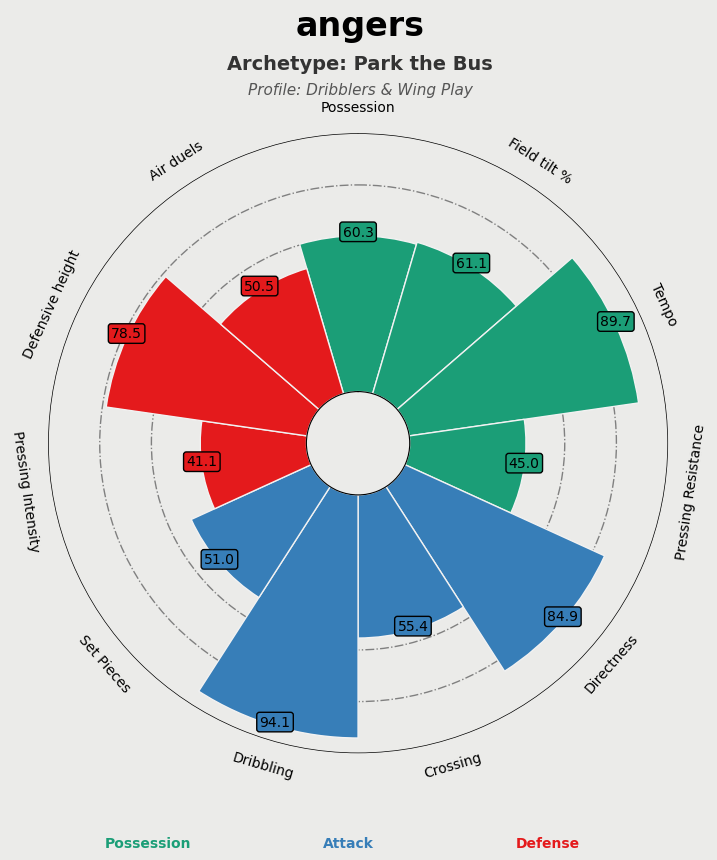

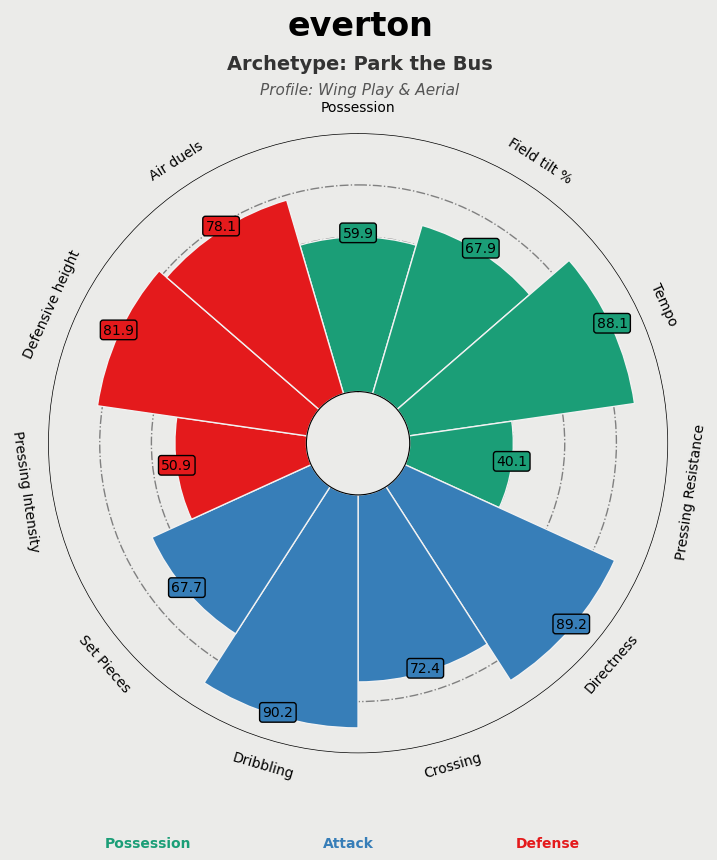

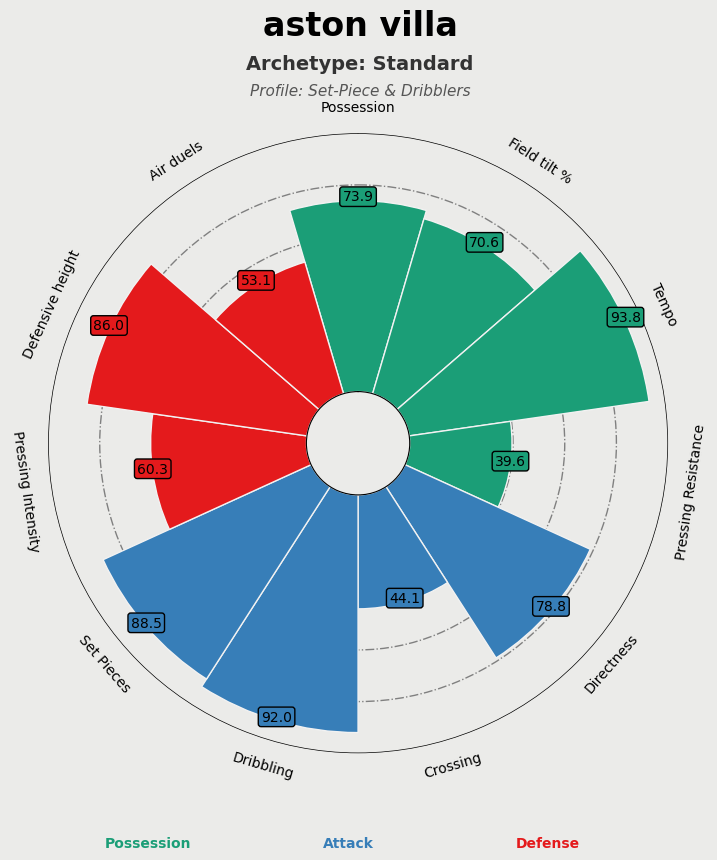

In [10]:
from mplsoccer import PyPizza
import random

# --- SETTINGS ---
features_ordered = [
    # Possession / Control (Green)
    'Possession', 'Field tilt %', 'Tempo', 'Pressing Resistance',
    # Attack / Creation (Blue)
    'Directness', 'Crossing', 'Dribbling', 'Set Pieces',
    # Defense / Pressing (Red)
    'Pressing Intensity', 'Defensive height', 'Air duels'
]

# 2. Pick 3 Random Teams 
all_teams = df_style_final['Team'].unique().tolist()
random_teams = random.sample(all_teams, 3) 

print(f"Generating charts for: {random_teams}")

# --- LOOP TO GENERATE PLOTS ---
for team_name in random_teams:
    
    # Get data for the specific team
    team_subset = df_style_final[df_style_final['Team'] == team_name]
    
    if len(team_subset) == 0:
        print(f"Skipping {team_name}: No data found.")
        continue
        
    team_data = team_subset.iloc[0]
    
    # Extract values
    values = [round(team_data[p], 1) for p in features_ordered]
    

    main_style = team_data['Main_Style']
    tactical_dna = team_data['Tactical_Profile']

    # --- PIZZA CHART SETUP ---
    
    # Colors: 4 Green (Possession), 4 Blue (Attack), 3 Red (Defense)
    slice_colors = ["#1b9e77"] * 4 + ["#377eb8"] * 4 + ["#e41a1c"] * 3
    text_colors = ["#000000"] * len(features_ordered)

    baker = PyPizza(
        params=features_ordered,
        background_color="#EBEBE9",
        straight_line_color="#EBEBE9",
        straight_line_lw=1,
        last_circle_lw=1,
        other_circle_lw=1,
        other_circle_ls="-.",
        inner_circle_size=20
    )

    # Generate the figure
    fig, ax = baker.make_pizza(
        values,
        figsize=(8, 8.5),      
        param_location=110,
        slice_colors=slice_colors,
        value_colors=text_colors,
        value_bck_colors=slice_colors,
        kwargs_slices=dict(
            edgecolor="#F2F2F2", zorder=2, linewidth=1
        ),
        kwargs_params=dict(
            color="#000000", fontsize=10, va="center"
        ),
        kwargs_values=dict(
            color="#FFFFFF", fontsize=10, zorder=3,
            bbox=dict(
                edgecolor="#000000", boxstyle="round,pad=0.2", lw=1
            )
        )
    )


    # 1. Team Name
    fig.text(
        0.515, 0.975, f"{team_name}", size=24,
        ha="center", color="#000000", weight='bold'
    )
    
    # 2. Main Archetype (e.g., "Gegenpressing")
    fig.text(
        0.515, 0.935, f"Archetype: {main_style}", size=14,
        ha="center", color="#333333", weight='bold'
    )
    
    # 3. Tactical Profile (e.g., "High Tempo & Dribblers")
    fig.text(
        0.515, 0.905, f"Profile: {tactical_dna}", size=11,
        ha="center", color="#555555", style='italic'
    )

    # Legend for categories
    fig.text(0.25, 0.02, "Possession", color="#1b9e77", size=10, weight='bold', ha="center")
    fig.text(0.50, 0.02, "Attack", color="#377eb8", size=10, weight='bold', ha="center")
    fig.text(0.75, 0.02, "Defense", color="#e41a1c", size=10, weight='bold', ha="center")

    plt.show() 

🎲 Randomly Selected Team: barcelona


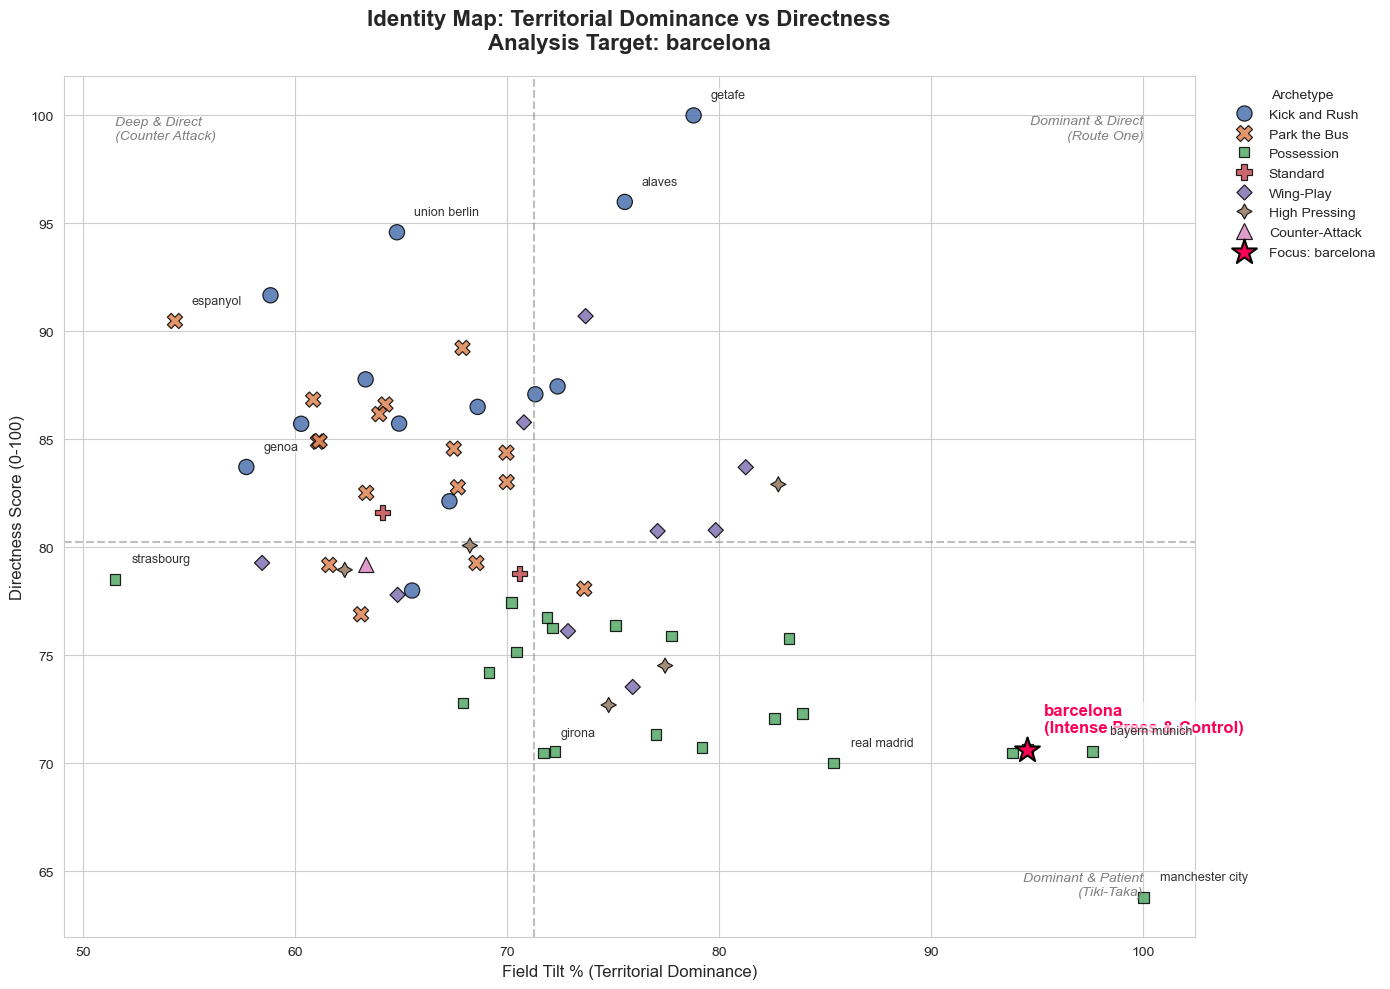

In [11]:
import seaborn as sns

# --- SETTINGS ---

# 1. Randomly Select a Team from the dataframe
all_teams = df_style_final['Team'].unique().tolist()
target_team = random.choice(all_teams)

print(f"🎲 Randomly Selected Team: {target_team}")

# --- 2. SCATTER PLOT ---

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# 1. Main Scatter Plot
sns.scatterplot(
    data=df_style_final, 
    x='Field tilt %', 
    y='Directness', 
    hue='Main_Style',     
    palette='deep',        
    style='Main_Style',    
    s=120,
    alpha=0.85,
    edgecolor='black'
)

# 2. Highlight the Specific Target Team
selected_team_data = df_style_final[df_style_final['Team'] == target_team]

plt.scatter(
    selected_team_data['Field tilt %'], 
    selected_team_data['Directness'], 
    color='#FF0055',       # Bright Pink/Red to pop out
    s=350, 
    marker='*', 
    edgecolor='black', 
    linewidth=1.5,
    zorder=10, 
    label=f'Focus: {target_team}'
)

# 3. Labeling Logic
# Label the target team + top outliers in each direction
teams_to_label = [target_team] 
teams_to_label += df_style_final.nlargest(3, 'Field tilt %')['Team'].tolist()  # Most Dominant
teams_to_label += df_style_final.nsmallest(3, 'Field tilt %')['Team'].tolist() # Deepest Defense
teams_to_label += df_style_final.nlargest(3, 'Directness')['Team'].tolist()    # Most Long Ball
teams_to_label += df_style_final.nsmallest(3, 'Directness')['Team'].tolist()   # Most Short Passing
teams_to_label = list(set(teams_to_label)) # Remove duplicates

for i in range(df_style_final.shape[0]):
    row = df_style_final.iloc[i]
    name = row['Team']
    x_val = row['Field tilt %']
    y_val = row['Directness']
    
    if name in teams_to_label:
        if name == target_team:
            font_weight = 'bold'
            color = '#FF0055' 
            fontsize = 12
            
            if 'Tactical_Profile' in df_style_final.columns:
                profile = row['Tactical_Profile']
                label_text = f"{name}\n({profile})"
            else:
                label_text = name
        else:
            font_weight = 'normal'
            color = '#333333'
            fontsize = 9
            label_text = name
            
        plt.text(
            x_val + 0.8, y_val + 0.8, label_text, 
            fontsize=fontsize, weight=font_weight, color=color, zorder=11,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5)
        )

# 4. Titles and Reference Lines
plt.title(f'Identity Map: Territorial Dominance vs Directness\nAnalysis Target: {target_team}', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Field Tilt % (Territorial Dominance)', fontsize=12)
plt.ylabel('Directness Score (0-100)', fontsize=12)

# Mean Lines (Quadrants)
plt.axhline(df_style_final['Directness'].mean(), linestyle='--', color='gray', alpha=0.5)
plt.axvline(df_style_final['Field tilt %'].mean(), linestyle='--', color='gray', alpha=0.5)

# Add Quadrant Context Labels
# Top Right
plt.text(df_style_final['Field tilt %'].max(), df_style_final['Directness'].max(), 
         "Dominant & Direct\n(Route One)", ha='right', va='top', fontsize=10, color='gray', style='italic')
# Bottom Right
plt.text(df_style_final['Field tilt %'].max(), df_style_final['Directness'].min(), 
         "Dominant & Patient\n(Tiki-Taka)", ha='right', va='bottom', fontsize=10, color='gray', style='italic')
# Top Left
plt.text(df_style_final['Field tilt %'].min(), df_style_final['Directness'].max(), 
         "Deep & Direct\n(Counter Attack)", ha='left', va='top', fontsize=10, color='gray', style='italic')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Archetype', frameon=False)
plt.tight_layout()
plt.show()

In [42]:
# 1. Select columns to add 
new_insights = df_style_final[['Team', 'Main_Style', 'Tactical_Profile']]

# 2. Merge into the original combined_df
final_merged_data = pd.merge(combined_df, new_insights, on='Team', how='left')

# 3. Save to CSV
output_filename = "Final_Team_Data_With_Styles_2025.csv"
final_merged_data.to_csv(output_filename, index=False)

print(final_merged_data[['Team', 'Main_Style', 'Tactical_Profile']].head())

          Team     Main_Style                Tactical_Profile
0       alaves  Kick and Rush           Wing Play & Set-Piece
1       angers   Park the Bus           Dribblers & Wing Play
2      arsenal     Possession  Field tilt % & Press Resistant
3  aston villa       Standard           Set-Piece & Dribblers
4     atalanta     Possession      Cross-Heavy & Field tilt %


In [44]:
import os 

documents = os.path.join(os.path.expanduser("~"), "Documents")

df_style_final.to_csv(os.path.join(documents,"Team_Playstyles_2025.csv"), index=False)
